In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

In [2]:
sales_of_company = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

all_series = {
    "Sales": sales_of_company["Count"],
    "Robberies": robberies_in_boston["Count"],
    "Temperature": mean_monthly_temp["Deg"],
    "Dow_Jones": dowjones_closing["Close"],
    "Births": female_births["Count"]
}

1. Испольузем ряд Dow_Jones

Для начала используем скользящее среднее

In [3]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

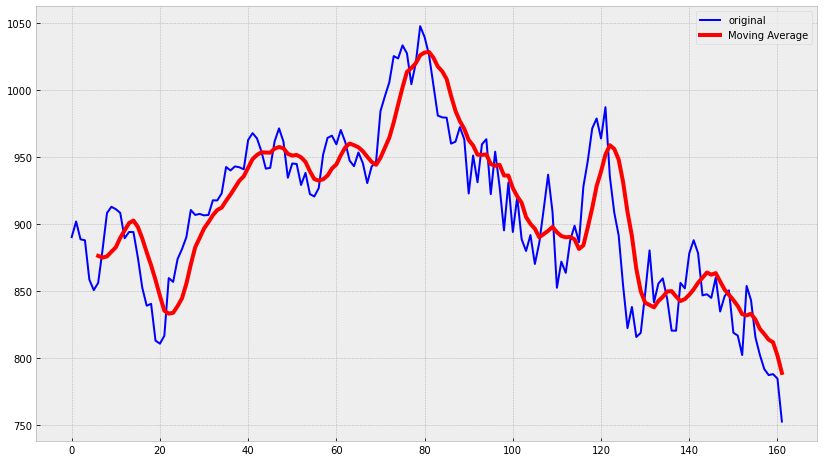

In [4]:
#Испольузем метод с окном в 7 элементов
ser = moving_average(all_series['Dow_Jones'], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series['Dow_Jones'], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [5]:
error_ma = mean_squared_error(ser[7:], all_series['Dow_Jones'][7:]) 
error_ma

699.6449390125052

Теперь попробуем использовать взвешенную скользящую средную

In [7]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

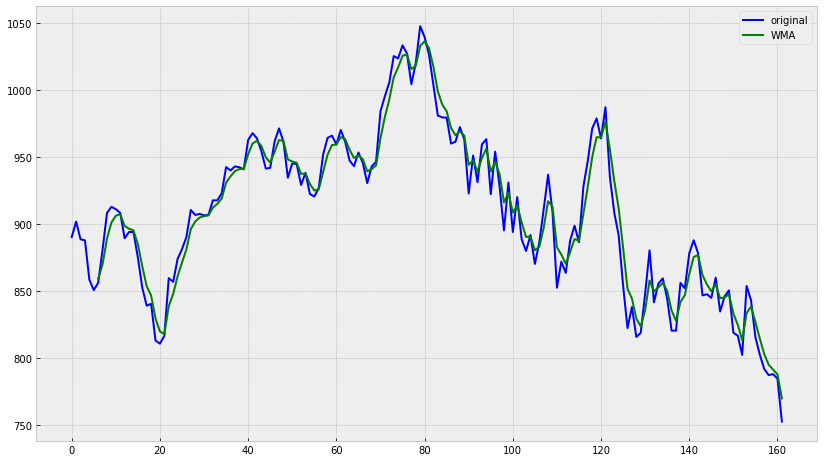

In [8]:
wma = weighted_moving_average(all_series['Dow_Jones'], 7, [1,2,4,8,16,32,64])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series['Dow_Jones'], color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

Рассмотрим MSE для разных наборов коэффициентов 

In [10]:
wma = weighted_moving_average(all_series['Dow_Jones'], 7, [1,2,3,4,5,6,7])
error_wma = mean_squared_error(wma[7:], all_series['Dow_Jones'][7:]) 
error_wma

393.7441178826531

In [11]:
wma = weighted_moving_average(all_series['Dow_Jones'], 7, [1,1,2,3,5,8,13])
error_wma = mean_squared_error(wma[7:], all_series['Dow_Jones'][7:]) 
error_wma

215.69133768061846

In [14]:
wma = weighted_moving_average(all_series['Dow_Jones'], 7, [1,4,8,16,64,128,256])
error_wma = mean_squared_error(wma[7:], all_series['Dow_Jones'][7:]) 
error_wma

99.54524419911861

Наименьшая ошибка получается при наборе коэффициентов - 1,4,8,16,64,128,256 - с большим влиянием бижайших предудщих элементов

Теперь применим двойное экспоненциальное сглаживание с большим влиянием предыдущего элемента - 0.95

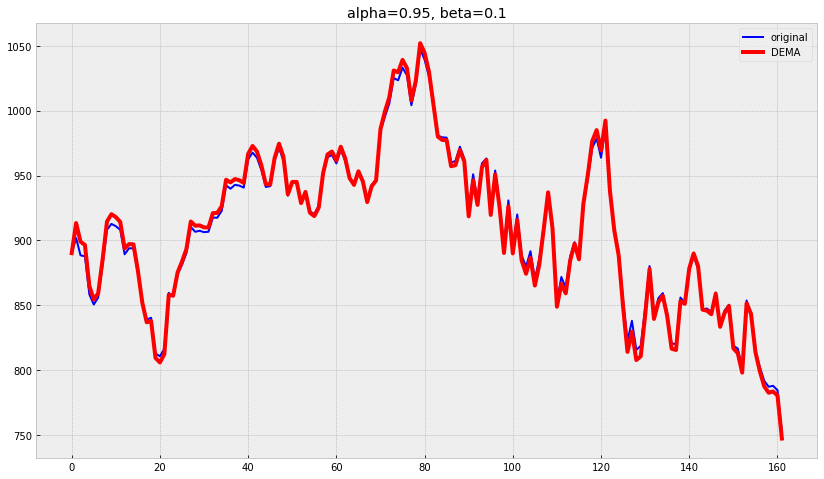

In [16]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

def plot_dema(alpha, beta):
    dema = double_ema(all_series['Dow_Jones'], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(all_series['Dow_Jones'], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()
        
plot_dema(0.95, 0.1)

In [19]:
dema = double_ema(all_series['Dow_Jones'], 0.6, 0.2)
error_dema = mean_squared_error(dema, all_series['Dow_Jones']) 
error_dema

91.496604309635

In [21]:
dema = double_ema(all_series['Dow_Jones'], 0.8, 0.1)
error_dema = mean_squared_error(dema, all_series['Dow_Jones']) 
error_dema

27.429362113760025

In [78]:
dema = double_ema(all_series['Dow_Jones'], 0.99, 0.05)
error_dema = mean_squared_error(dema, all_series['Dow_Jones']) 
error_dema

12.736457272719814

Наименьшая ошибка получается при большом влиянии предыдущего элемента и маленьком влиянии дальшеотстоящих элементах
Это связано с тем, что ряд не имеет сезонности и тренда

2. Теперь Испольузем ряд рождаемости девочек в Калифорнии

Еща раз используем взвешенную скользящую средную со следующим набором коэффициентов - 1,8,16,64,128,256,512 для окна 7 элементов

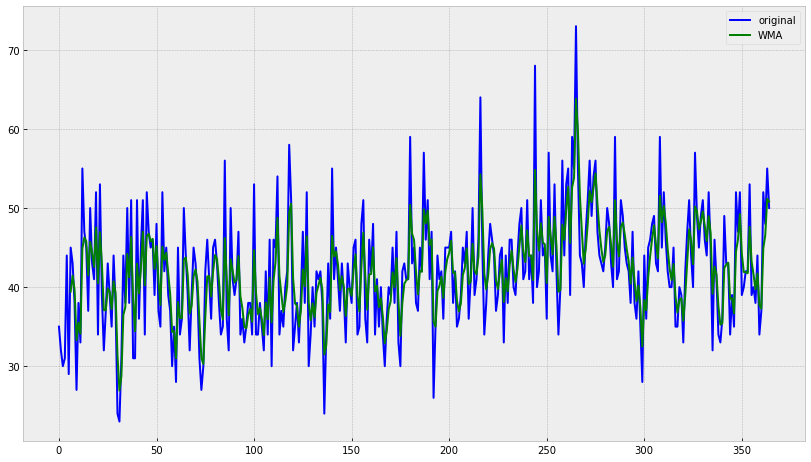

In [32]:
wma_2 = weighted_moving_average(all_series['Births'], 7, [1,8,16,64,128,256,512])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series['Births'], color='blue',label='original')
    plt.plot(wma_2, color='green', linewidth='2', label='WMA')
    plt.legend()

In [34]:
#dema = double_ema(all_series['Dow_Jones'], 0.95, 0.1)
error_wma_2 = mean_squared_error(wma_2[7:], all_series['Births'][7:]) 
error_wma_2

14.09895387970106

Используем Экспоненциальное сглаживание

In [25]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

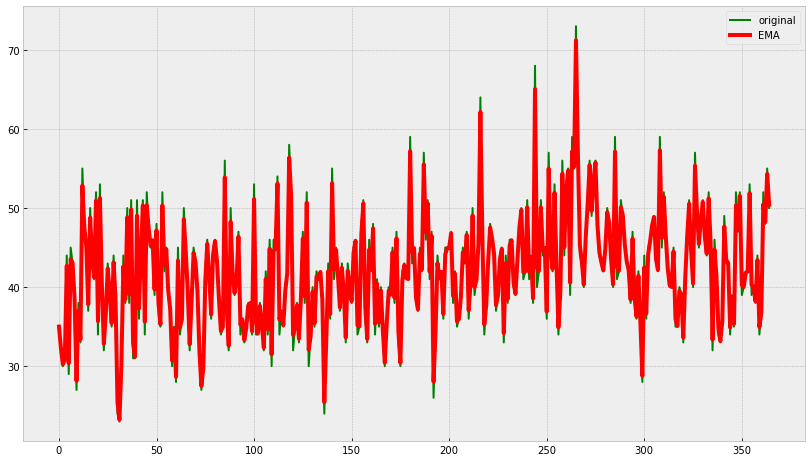

In [31]:
ema = exponential_moving_average(all_series['Births'], 0.9)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series['Births'], color='green',label='original')
    plt.plot(ema, color='red', linewidth='4', label='EMA')
    plt.legend()

In [35]:
error_ema_2 = mean_squared_error(ema, all_series['Births']) 
error_ema_2

0.769684465913359

Это очень хорошая ошибка из всех методов кроме Хольта

Теперь используем Хольта-Винтерса

In [41]:
def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [42]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [43]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

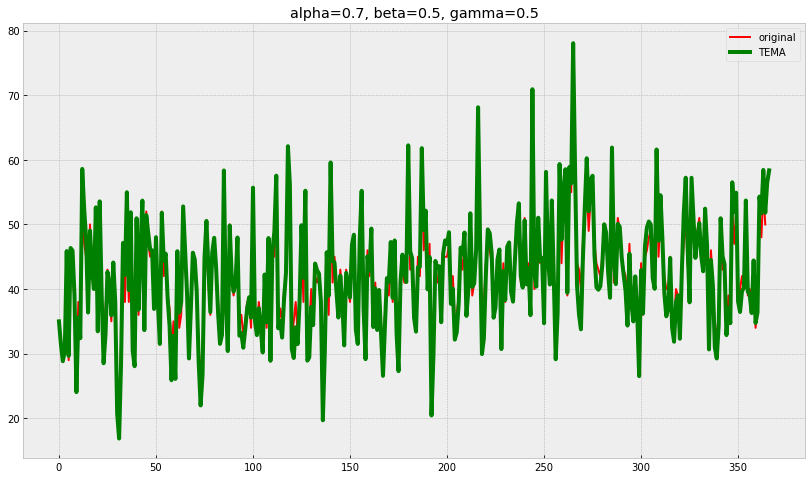

In [49]:
def plot_tema(alpha, beta, gamma, ser=all_series['Births'], ser_to_plot=all_series['Births'], n_preds=2):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='red',label='original')
        plt.plot(tema, color='green', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
        
plot_tema(0.7, 0.5, 0.5)

In [72]:
tema = triple_exponential_smoothing(all_series['Births'], 12, 0.75, 0.1, 0.8, 0)
error_hv = mean_squared_error(tema, all_series['Births']) 
error_hv

0.2597101603692095

Это минимальная ошибка из всех методов потому что этот метод учитывает сезонность